In [1]:
import os, gzip, pickle, glob

import pandas as pd
import numpy as np

from multiprocessing import  Pool

from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import PandasTools

from rdkit import Chem, rdBase, RDConfig
from rdkit.Chem import AllChem, rdShapeHelpers
from rdkit.Chem.FeatMaps import FeatMaps, FeatMapUtils
from rdkit.Chem.FeatMaps.FeatMapUtils import CombineFeatMaps

import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go

In [2]:
pkl_file = open('featurestein-69.p', 'rb')
fmaps = pickle.load(pkl_file)
fmaps

In [3]:
fmaps.params

{'Donor': <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams at 0x7f01fde65a00>,
 'Acceptor': <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams at 0x7f01fde65b20>,
 'NegIonizable': <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams at 0x7f01fde65c40>,
 'PosIonizable': <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams at 0x7f01fde65d00>,
 'ZnBinder': <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams at 0x7f01fde65c10>,
 'Aromatic': <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams at 0x7f01fde5f4c0>,
 'Hydrophobe': <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams at 0x7f01fde5f4f0>,
 'LumpedHydrophobe': <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams at 0x7f01fde5f6d0>}

In [4]:
# Setting up the features to use in FeatureMap
ffact = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))

keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')

fmParams = {}
for k in ffact.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

def filterFeature(f):
    result = f.GetFamily() in keep
    return result

def getRawFeatures(mol):
    rawFeats = ffact.GetFeaturesForMol(mol)
    # filter that list down to only include the ones we're interested in
    filtered = list(filter(filterFeature, rawFeats))
    return filtered

def getFeatureMap(mol):
    feats = getRawFeatures(mol)
    return FeatMaps.FeatMap(feats=feats, weights=[1]*len(feats),params=fmParams)

def gen_feats(mol):
    rawFeats = getRawFeatures(mol)
    return FeatMaps.FeatMap(feats=feats, weights=[1]*len(rawFeats), params=fmParams)

def score_featmaps(fm1, fm2):
    "Generate the score for 2 feature maps"
    if fm1.GetNumFeatures() == 0:
        return 0
    else:
        return fm1.ScoreFeats(fm2.GetFeatures()) / fm1.GetNumFeatures()

def gen_fmap_score(mol):
    featMap = getFeatureMap(mol)
    score = score_featmaps(featMap, fmaps)
    return score

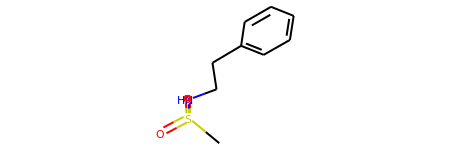

In [5]:
# Run a simple test - the Mpro-x0072 hit which should score close to 1.0
mol = Chem.MolFromMolFile('../data/misc/Mpro-x0072.mol')
mol

In [6]:
score = gen_fmap_score(mol)
score

0.9538538108436915

In [7]:
%%time
# Load and merge the datasets and merge into a single dataframe
# This takes about 1 hour
base = '../data/frag-followup/gen3/'
files =  glob.glob(base + 'Mpro-x*-into-x*.sdf.gz')

# Adjust this to change the number of best poses to retain
keep_best_n = 10

print('Number of files:', len(files))
df = None
count = 0
for file in sorted(files):
    count += 1
    name = file[len(base)+5:len(base)+21]
    ligand = file[len(base)+5:len(base)+10]
    receptor = file[len(base)+16:len(base)+21]
    print('Loading dataset', count, name, ligand, receptor)
    df2 = PandasTools.LoadSDF(file, molColName='Molecule')
    print('  read', df2.shape)
    df2['Receptor'] = 'Mpro-' + receptor + '_0'
    if df is None:
        df = df2
    else:
        df = df.append(df2)
    df = df.groupby(["Name"])
    df = df.apply(lambda x: x.sort_values(['SCORE'], ascending=True))
    df = df.reset_index(drop=True)
    df = df.groupby('Name').head(keep_best_n)
    print('  dataframe shape:', df.shape)
    
print('Loading complete')

Number of files: 92
Loading dataset 1 x0072-into-x0305 x0072 x0305
  read (9834, 55)
  dataframe shape: (9834, 56)
Loading dataset 2 x0072-into-x0387 x0072 x0387
  read (24739, 55)
  dataframe shape: (34573, 56)
Loading dataset 3 x0072-into-x0874 x0072 x0874
  read (8872, 55)
  dataframe shape: (36227, 56)
Loading dataset 4 x0072-into-x1249 x0072 x1249
  read (13270, 55)
  dataframe shape: (39381, 56)
Loading dataset 5 x0104-into-x0305 x0104 x0305
  read (9030, 55)
  dataframe shape: (48411, 56)
Loading dataset 6 x0104-into-x0387 x0104 x0387
  read (12583, 55)
  dataframe shape: (60994, 56)
Loading dataset 7 x0104-into-x0874 x0104 x0874
  read (10173, 55)
  dataframe shape: (63705, 56)
Loading dataset 8 x0104-into-x1249 x0104 x1249
  read (10470, 55)
  dataframe shape: (64750, 56)
Loading dataset 9 x0107-into-x0305 x0107 x0305
  read (21319, 55)
  dataframe shape: (86069, 56)
Loading dataset 10 x0107-into-x0387 x0107 x0387
  read (18624, 55)
  dataframe shape: (104693, 56)
Loading data

  read (2582, 55)
  dataframe shape: (644597, 56)
Loading dataset 85 x1249-into-x0305 x1249 x0305
  read (9587, 55)
  dataframe shape: (654184, 56)
Loading dataset 86 x1249-into-x0387 x1249 x0387
  read (13449, 55)
  dataframe shape: (667633, 56)
Loading dataset 87 x1249-into-x0874 x1249 x0874
  read (11222, 55)
  dataframe shape: (669560, 56)
Loading dataset 88 x1249-into-x1249 x1249 x1249
  read (10796, 55)
  dataframe shape: (669942, 56)
Loading dataset 89 x2193-into-x0305 x2193 x0305
  read (310, 55)
  dataframe shape: (670252, 56)
Loading dataset 90 x2193-into-x0387 x2193 x0387
  read (4968, 55)
  dataframe shape: (675220, 56)
Loading dataset 91 x2193-into-x0874 x2193 x0874
  read (316, 55)
  dataframe shape: (675504, 56)
Loading dataset 92 x2193-into-x1249 x2193 x1249
  read (407, 55)
  dataframe shape: (675843, 56)
Loading complete
CPU times: user 50min 50s, sys: 43.4 s, total: 51min 33s
Wall time: 51min 29s


In [8]:
df.dtypes

CHROM.1                       object
EmbedRMS                      object
Hit                           object
Name                          object
RI                            object
Rbt.Current_Directory         object
Rbt.Executable                object
Rbt.Library                   object
Rbt.Parameter_File            object
Rbt.Receptor                  object
SCORE                         object
SCORE.INTER                   object
SCORE.INTER.CONST             object
SCORE.INTER.POLAR             object
SCORE.INTER.REPUL             object
SCORE.INTER.ROT               object
SCORE.INTER.VDW               object
SCORE.INTER.norm              object
SCORE.INTRA                   object
SCORE.INTRA.DIHEDRAL          object
SCORE.INTRA.DIHEDRAL.0        object
SCORE.INTRA.POLAR             object
SCORE.INTRA.POLAR.0           object
SCORE.INTRA.REPUL             object
SCORE.INTRA.REPUL.0           object
SCORE.INTRA.VDW               object
SCORE.INTRA.VDW.0             object
S

In [9]:
df_pruned = df[['Name', 'Molecule', 'Hit', 'Receptor', 'SCORE', 'SCORE.norm', 'SCORE.heavy', 'SuCOS_Score', 
                'Max_SuCOS_Score', 'Cum_SuCOS_Score', 'TransFSScore_50nM', 'TransFSScore_1uM', 
                'TransFSScore_10nM', 'TransFSScore_200nM']]

df_pruned = df_pruned.astype(dtype= {
    'SCORE':'float64',
    'SCORE.norm':'float64',
    'SCORE.heavy':'int64',
    'SuCOS_Score':'float64',
    'Max_SuCOS_Score':'float64',
    'Cum_SuCOS_Score':'float64',
    'TransFSScore_50nM':'float64',
    'TransFSScore_1uM':'float64',
    'TransFSScore_10nM':'float64',
    'TransFSScore_200nM':'float64'
})
df_pruned['TransFSScore'] = (df_pruned['TransFSScore_50nM'] + df_pruned['TransFSScore_1uM'] + 
                            df_pruned['TransFSScore_10nM'] + df_pruned['TransFSScore_200nM']) /4
df_pruned.dtypes

Name                   object
Molecule               object
Hit                    object
Receptor               object
SCORE                 float64
SCORE.norm            float64
SCORE.heavy             int64
SuCOS_Score           float64
Max_SuCOS_Score       float64
Cum_SuCOS_Score       float64
TransFSScore_50nM     float64
TransFSScore_1uM      float64
TransFSScore_10nM     float64
TransFSScore_200nM    float64
TransFSScore          float64
dtype: object

,Name,Molecule,Hit,Receptor,SCORE,SCORE.norm,SCORE.heavy,SuCOS_Score,Max_SuCOS_Score,Cum_SuCOS_Score,TransFSScore_50nM,TransFSScore_1uM,TransFSScore_10nM,TransFSScore_200nM,TransFSScore
0,BrC(CC1CCC1)c1ccccc1,,Mpro-x0072_0,Mpro-x0387_0,-6.05800,-0.466000,13,0.487310,0.487310,5.199969,0.016474,0.346283,0.008455,0.081581,0.113198
1,BrC(CC1CCC1)c1ccccc1,,Mpro-x0072_0,Mpro-x0387_0,-6.10223,-0.469402,13,0.497033,0.497033,5.235664,0.017748,0.329703,0.007349,0.075790,0.107648
2,BrC(CC1CCC1)c1ccccc1,,Mpro-x0072_0,Mpro-x0387_0,-6.14613,-0.472779,13,0.509504,0.509504,5.334861,0.010172,0.333669,0.005738,0.061117,0.102674
3,BrC(CC1CCC1)c1ccccc1,,Mpro-x0072_0,Mpro-x0387_0,-6.20808,-0.477545,13,0.490168,0.490168,5.248980,0.011915,0.350252,0.006130,0.060114,0.107103
4,BrC(CC1CCC1)c1ccccc1,,Mpro-x0072_0,Mpro-x0387_0,-6.21846,-0.478343,13,0.506257,0.506257,5.328303,0.009868,0.334691,0.005567,0.061209,0.102834

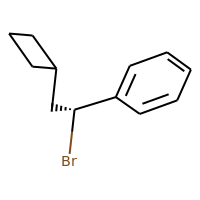
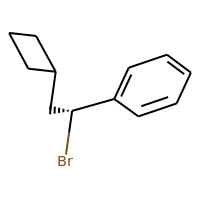
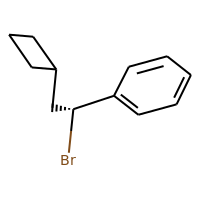
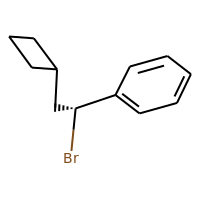
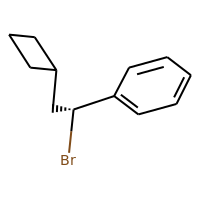

In [10]:
df_pruned.head()

In [11]:
def parallelize_dataframe(df, func, n_cores=8):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def calc_fmscore(df):
    df['FeatureSteinScore'] = df['Molecule'].apply(gen_fmap_score)
    return df

In [12]:
%%time
#dfx = parallelize_dataframe(df_pruned, calc_fmscore, n_cores=2)
dfx = df_pruned
dfx['FeatureSteinScore'] = dfx.apply(lambda row: gen_fmap_score(row['Molecule']), axis=1)

CPU times: user 55min 22s, sys: 1.13 s, total: 55min 23s
Wall time: 55min 24s


df_pruned['FeatureSteinScore'] = df_pruned.apply(lambda row: gen_fmap_score(row['Molecule']), axis=1)
df_pruned.shape

,Name,Molecule,Hit,Receptor,SCORE,SCORE.norm,SCORE.heavy,SuCOS_Score,Max_SuCOS_Score,Cum_SuCOS_Score,TransFSScore_50nM,TransFSScore_1uM,TransFSScore_10nM,TransFSScore_200nM,TransFSScore,FeatureSteinScore
0,BrC(CC1CCC1)c1ccccc1,,Mpro-x0072_0,Mpro-x0387_0,-6.05800,-0.466000,13,0.487310,0.487310,5.199969,0.016474,0.346283,0.008455,0.081581,0.113198,0.426253
1,BrC(CC1CCC1)c1ccccc1,,Mpro-x0072_0,Mpro-x0387_0,-6.10223,-0.469402,13,0.497033,0.497033,5.235664,0.017748,0.329703,0.007349,0.075790,0.107648,0.437256
2,BrC(CC1CCC1)c1ccccc1,,Mpro-x0072_0,Mpro-x0387_0,-6.14613,-0.472779,13,0.509504,0.509504,5.334861,0.010172,0.333669,0.005738,0.061117,0.102674,0.492736
3,BrC(CC1CCC1)c1ccccc1,,Mpro-x0072_0,Mpro-x0387_0,-6.20808,-0.477545,13,0.490168,0.490168,5.248980,0.011915,0.350252,0.006130,0.060114,0.107103,0.468778
4,BrC(CC1CCC1)c1ccccc1,,Mpro-x0072_0,Mpro-x0387_0,-6.21846,-0.478343,13,0.506257,0.506257,5.328303,0.009868,0.334691,0.005567,0.061209,0.102834,0.494798

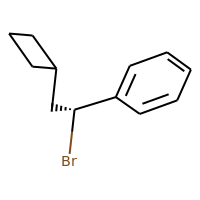
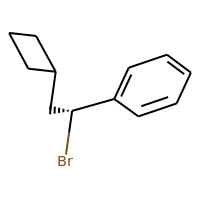
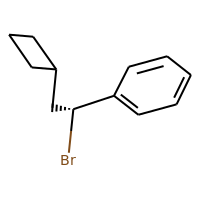
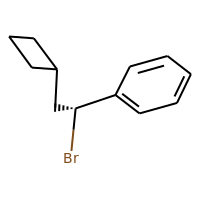
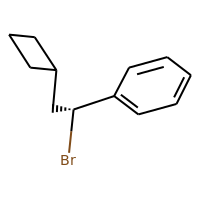

In [13]:
dfx.head()

In [14]:
w = Chem.SDWriter('ScoreGalaxyGen3Ligands.sdf')

count = 0

for index, row in dfx.iterrows():
    mol = row['Molecule']
    mol.SetProp('IsoSmiles', Chem.MolToSmiles(mol, isomericSmiles=True))
    mol.SetProp('NonisoSmiles', Chem.MolToSmiles(mol, isomericSmiles=False))
    mol.SetProp('Hit', row['Hit'])
    mol.SetProp('Receptor', row['Receptor'])
    mol.SetDoubleProp('SCORE', row['SCORE'])
    mol.SetDoubleProp('SCORE.norm', row['SCORE.norm'])
    mol.SetIntProp('SCORE.heavy', row['SCORE.heavy'])
    mol.SetProp('OrigSmiles', row['Name'])
    mol.SetDoubleProp('SuCOS_Score', row['SuCOS_Score'])
    mol.SetDoubleProp('Max_SuCOS_Score', row['Max_SuCOS_Score'])
    mol.SetDoubleProp('Cum_SuCOS_Score', row['Cum_SuCOS_Score'])
    mol.SetDoubleProp('TransFSScore_50nM', row['TransFSScore_50nM'])
    mol.SetDoubleProp('TransFSScore_1uM', row['TransFSScore_1uM'])
    mol.SetDoubleProp('TransFSScore_10nM', row['TransFSScore_10nM'])
    mol.SetDoubleProp('TransFSScore_200nM', row['TransFSScore_200nM'])
    mol.SetDoubleProp('TransFSScore', row['TransFSScore'])
    mol.SetDoubleProp('FeatureSteinScore', row['FeatureSteinScore'])
    
    if Chem.FindMolChiralCenters(mol, force=True, includeUnassigned=True):
        mol.SetProp('_MolFileChiralFlag', '1')
    
    w.write(mol)
    count += 1

w.close()
print('Wrote', count, 'molecules with ', keep_best_n, 'best poses for each molecule')

Wrote 675843 molecules with  10 best poses for each molecule


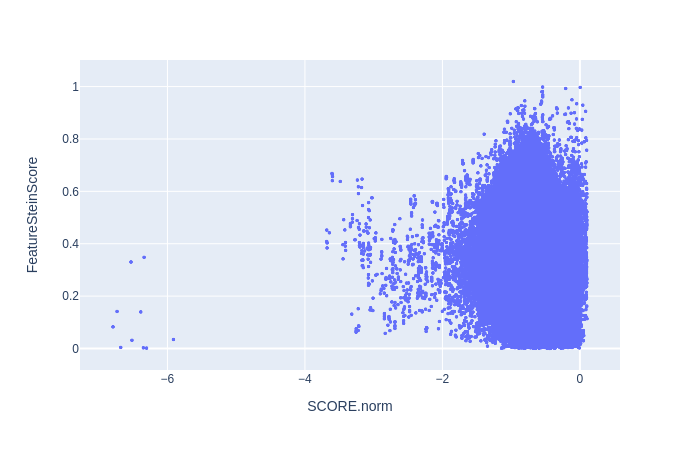

In [15]:
fig = px.scatter(dfx, x="SCORE.norm", y="FeatureSteinScore")
fig.update_traces(mode='markers', marker_size=3)
fig.show(renderer='png')

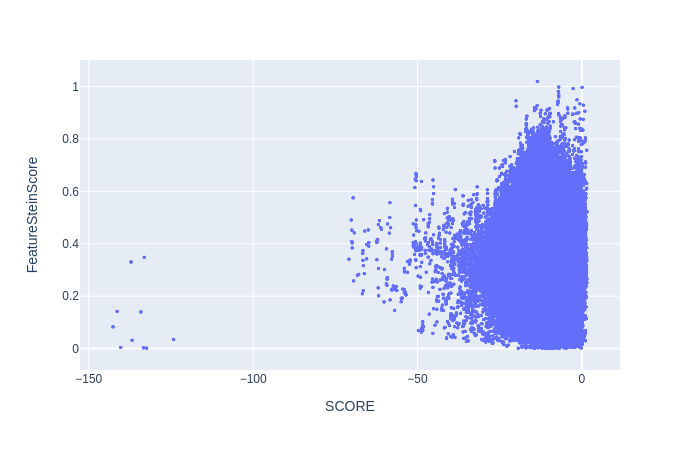

In [16]:
fig = px.scatter(dfx, x="SCORE", y="FeatureSteinScore")
fig.update_traces(mode='markers', marker_size=3)
fig.show(renderer='png')